In [5]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

Prompt used to generate a bunch of queries
```
I am implementing a chat for a online shop. This shop sells anything (for example, think about Amazon). I want to test my system with user queries. Generate a list of user queries in a JSON format. Generate for example 1000 queries using the format ["query1", "query2", ...]
```
Then, I continued the chat using `Continue`

# Tools

In [23]:
def most_common(lst):
    return max(set(lst), key=lst.count)

def compute_one_rate(articles_numbers):
    positions, counts = np.unique(articles_numbers, return_counts=True)
    positions_count = {str(position): n for position, n in zip(positions, counts)}
    one_rate = positions_count['1'] / len(articles_numbers)
    return one_rate


def compute_minmax_diff(articles_numbers):
    positions, counts = np.unique(articles_numbers, return_counts=True)
    if positions[0] == -1:
        positions = positions[1:]
        counts = counts[1:]
    minmax_diff = max(counts) - min(counts)
    return minmax_diff


def load_results(path):
    with open(path, 'r') as f:
        data = json.load(f)

    results = [
        most_common([replica['parsed_response']['article_number'] for replica in sample if replica['parsed_response'] is not None])
        for sample in data['results']
    ]

    return results

# Single run

[5, 4, 4, 2, 2, 2, 2, 3, 1, 3, 3, 2, 1, 3, 1, 3, 2, 2, 1, 5, 3, 1, 2, 2, 3, 1, 3, 1, 3, 1, 4, 3, 3, 1, 4, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 3]


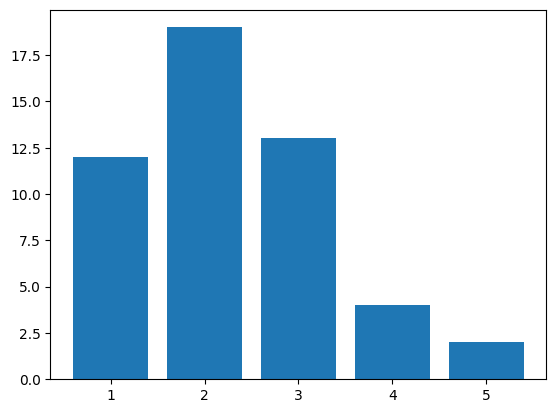

In [36]:
experiment_path = os.path.join('..', 'results', 'variance_reduction', 'icl_order__quantization_level', 'llama3.1:8b-instruct-q5_K_M.json')

with open(experiment_path, 'r') as f:
    data = json.load(f)

articles_numbers = [
    most_common([replica['parsed_response']['article_number'] for replica in sample if replica['parsed_response'] is not None])
    for sample in data['results']
]

print(articles_numbers)

positions, counts = np.unique(articles_numbers, return_counts=True)


plt.bar(positions, counts)
plt.show()

In [8]:
positions_count = {
    str(position): n for position, n in zip(positions, counts)
}


one_rate = positions_count['1'] / len(articles_numbers)
error_rate = positions_count['-1'] if '-1' in positions_count else 0 / len(articles_numbers)
counts_mean = np.mean(counts)
counts_std = np.std(counts)


print(f'One rate: {one_rate*100:.2f}%')
print(f'Error rate: {error_rate*100:.2f}%')
print(f'Histogram stats: {counts_mean:.2f} (+-{counts_std:.4f})')

One rate: 48.00%
Error rate: 0.00%
Histogram stats: 10.00 (+-7.7717)


# Model quantization

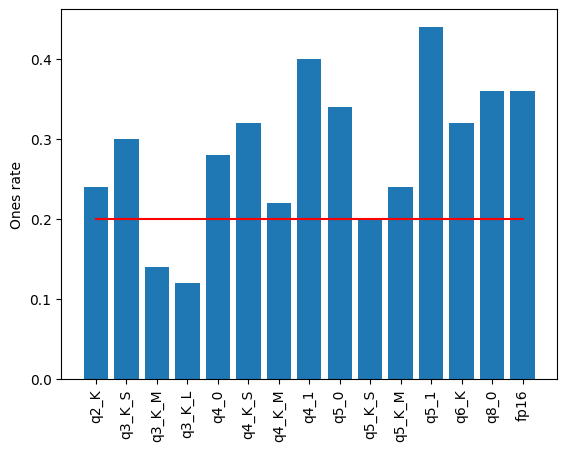

In [30]:
base_dir = os.path.join('..', 'results', 'variance_reduction', 'icl_order__quantization_level')
model_name = 'llama3.1'
model_version = '8b-instruct'
quantization_levels = [
    'q2_K',   # 3.2 GB
    'q3_K_S', # 3.7 GB
    'q3_K_M', # 4.0 GB
    'q3_K_L', # 4.3 GB
    'q4_0',   # 4.7 GB
    'q4_K_S', # 4.7 GB
    'q4_K_M', # 4.9 GB
    'q4_1',   # 5.1 GB
    'q5_0',   # 5.6 GB
    'q5_K_S', # 5.6 GB
    'q5_K_M', # 5.7 GB
    'q5_1',   # 6.1 GB
    'q6_K',   # 6.6 GB
    'q8_0',   # 8.5 GB
    'fp16'    # 16 GB
]
plot_name = 'Ones rate'

results = {q_level: load_results(os.path.join(base_dir, f'{model_name}:{model_version}-{q_level}.json')) for q_level in quantization_levels}

data_dict = {
    'Ones rate': {q_level: compute_one_rate(articles_numbers) for q_level, articles_numbers in results.items()},
    'Min/max diff': {q_level: compute_minmax_diff(articles_numbers) for q_level, articles_numbers in results.items()}
}

plt.bar(data_dict[plot_name].keys(), data_dict[plot_name].values())
plt.plot(data_dict[plot_name].keys(), [1/5]*len(data_dict[plot_name]), color='red')
plt.xticks(rotation=90)
plt.ylabel(plot_name)
plt.show()

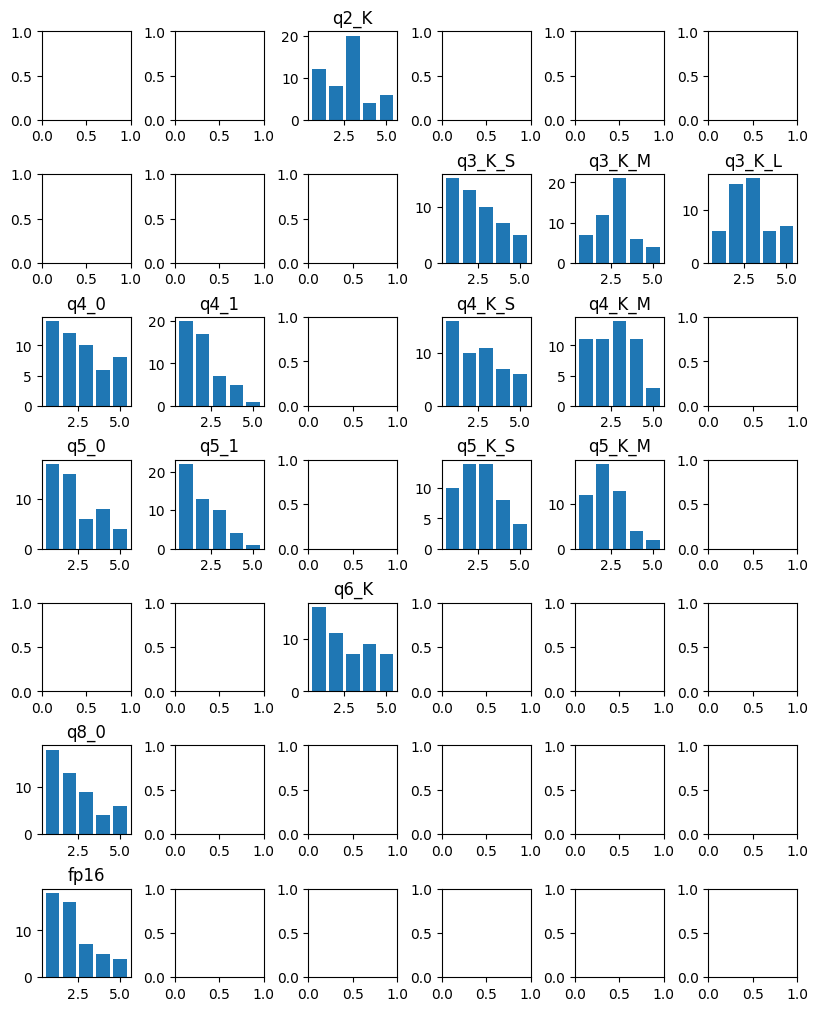

In [53]:
def plot_counts(experiment_path, title, ax=None):
    with open(experiment_path, 'r') as f:
        data = json.load(f)

    articles_numbers = [
        most_common([replica['parsed_response']['article_number'] for replica in sample if replica['parsed_response'] is not None])
        for sample in data['results']
    ]
    
    positions, counts = np.unique(articles_numbers, return_counts=True)

    if ax is None:
        ax = plt

    ax.bar(positions, counts)
    ax.set_title(title)

pos_map = {
    'q2_K':   (0, 2), # 3.2 GB
    'q3_K_S': (1, 3), # 3.7 GB
    'q3_K_M': (1, 4), # 4.0 GB
    'q3_K_L': (1, 5), # 4.3 GB
    'q4_0':   (2, 0), # 4.7 GB
    'q4_K_S': (2, 3), # 4.7 GB
    'q4_K_M': (2, 4), # 4.9 GB
    'q4_1':   (2, 1), # 5.1 GB
    'q5_0':   (3, 0), # 5.6 GB
    'q5_K_S': (3, 3), # 5.6 GB
    'q5_K_M': (3, 4), # 5.7 GB
    'q5_1':   (3, 1), # 6.1 GB
    'q6_K':   (4, 2), # 6.6 GB
    'q8_0':   (5, 0), # 8.5 GB
    'fp16':   (6, 0)  # 16 GB
}

fig, ax = plt.subplots(7, 6, constrained_layout=True, figsize=(8,10))

for q_level in pos_map:
    experiment_path = os.path.join(base_dir, f'{model_name}:{model_version}-{q_level}.json')
    row, col = pos_map[q_level]
    plot_counts(experiment_path, q_level, ax[row][col])

plt.show()